In [1]:
import torch 
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline  

import os 
import random

In [2]:
filename = os.path.join("datasets", "names.txt")

In [4]:
# Read in all the words 
words = open(filename, 'r').read().splitlines()
# build the vocabulary of characters and mappings to/from integers 
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0 
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
block_size = 3 
# build the dataset 

def build_dataset(words):
    X, Y = [], []
    for w in words:

        # print(w)
        context = [0] * block_size 
        for ch in w + '.': 
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '------->' ,itos[ix])
            context = context[1:] + [ix] # crop and append 


    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y 


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))


Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


In [6]:
# ok biolerplate done, now we get to the action 
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f"{s:15s} | exact: {str(ex):5s} | approximation: {str(app):5s} | maxdiff: {maxdiff}")

In [12]:
n_embd = 10 
n_hidden = 200


g = torch.Generator().manual_seed(2147483647)   # for reproducibility 
C = torch.randn((vocab_size, n_embd), generator=g)
# Layer 1 
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)  * (5/3)/((n_embd * block_size) ** 0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1
# Layer 2 
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g)    * 0.1


# Bash Normalization 
bngain = torch.ones((1, n_hidden)) * 0.1 + 1.0 
bnbias = torch.zeros((1, n_hidden)) * 0.1 

# bnmean_running = torch.ones((1, n_hidden))   # Will be updated during training 
# bnstd_running = torch.zeros((1, n_hidden))   # Will be updated during training 


parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters ))  # Number of parameters in total 
for p in parameters:
    p.requires_grad = True  

12297


In [13]:
batch_size = 32 
n = batch_size 
# construct a minibatch 
ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch x, y  

In [15]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time 
emb = C[Xb]  # embed the characters into vectors 
embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors 
# Linear layer 1 
hprebn = embcat @ W1 + b1  # hidden layer pre-activation 
# BatchNorm layer 
bnmean1 = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmean1 
bndiff2 = bndiff**2 
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias 
# Non-linearity 
h = torch.tanh(hpreact) # hidden layer 

# Linear layer 2 
logits = h @ W2 + b2 # output layer 
# cross entropy loss (smae as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values 
norm_logits = logits - logit_maxes  # subtract max for numerical stability 
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1 
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()


# PyTorch backward pass 
for p in parameters:
    p.grad = None 
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits, logit_maxes, logits, h, hpreact, bnraw, bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmean1, embcat, emb]:
    t.retain_grad()
loss.backward()
loss 



tensor(3.6560, grad_fn=<NegBackward0>)

In [35]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprops = (1.0 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprops).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprops
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts 
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1] ) * dlogit_maxes
dh = dlogits @ W2.T 
dW2  = h.T @ dlogits
db2 = dlogits.sum(0)
dhreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhreact).sum(0, keepdim=True)
dbnraw = (bngain * dhreact )
dbnbias = dhreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw 
dbnvar_inv = (bndiff * dbnraw ).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0 / (n-1)) * torch.ones_like(bndiff2) * dbnvar
dbndiff += (2 * bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
dhprebn += 1.0/n  * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1= dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]

cmp("logprobs", dlogprobs, logprobs)
cmp("probs", dprops, probs)
cmp("count_sum_inv", dcounts_sum_inv, counts_sum_inv)
cmp("count_sum", dcounts_sum, counts_sum)
cmp("count", dcounts, counts)
cmp("dnorm_logits", dnorm_logits, norm_logits)
cmp("dlogit_maxes", dlogit_maxes, logit_maxes)
cmp("dh", dh, h)
cmp("dW2", dW2, W2)
cmp("db2", db2, b2)
cmp("dhreact", dhreact, hpreact)
cmp("dbngain", dbngain, bngain)
cmp("dbnraw", dbnraw, bnraw)
cmp("dbnbias", dbnbias, bnbias)
cmp("dbndiff", dbndiff, bndiff)
cmp("dbnvar_inv", dbnvar_inv, bnvar_inv)
cmp("dbnvar", dbnvar, bnvar)
cmp("dbndiff2", dbndiff2, bndiff2)
cmp("dbnmeani", dbnmeani, bnmean1)
cmp("dhprebn", dhprebn, hprebn)
cmp("dembcat", dembcat, embcat)
cmp("dW1", dW1, W1)
cmp("db1", db1, b1)
cmp("demb", demb, emb)
cmp("dC", dC, C)

logprobs        | exact: True  | approximation: True  | maxdiff: 0.0
probs           | exact: True  | approximation: True  | maxdiff: 0.0
count_sum_inv   | exact: True  | approximation: True  | maxdiff: 0.0
count_sum       | exact: True  | approximation: True  | maxdiff: 0.0
count           | exact: True  | approximation: True  | maxdiff: 0.0
dnorm_logits    | exact: True  | approximation: True  | maxdiff: 0.0
dlogit_maxes    | exact: True  | approximation: True  | maxdiff: 0.0
dh              | exact: True  | approximation: True  | maxdiff: 0.0
dW2             | exact: True  | approximation: True  | maxdiff: 0.0
db2             | exact: True  | approximation: True  | maxdiff: 0.0
dhreact         | exact: True  | approximation: True  | maxdiff: 0.0
dbngain         | exact: True  | approximation: True  | maxdiff: 0.0
dbnraw          | exact: True  | approximation: True  | maxdiff: 0.0
dbnbias         | exact: True  | approximation: True  | maxdiff: 0.0
dbndiff         | exact: True  | a

In [ ]:
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1 
dlogits /= n 

cmp("logits", dlogits, logits)  # I can only get approximate to be true, my maxdiff is 6e-9


logits          | exact: False | approximation: True  | maxdiff: 6.51925802230835e-09


In [ ]:
dhprebn = bngain * bnvar_inv/n * (n*dhreact - dhreact.sum(0) - n/(n-1)*bnraw*(dhreact*bnraw).sum(0))

cmp("hprebn", dhprebn, hprebn)

hprebn          | exact: False | approximation: True  | maxdiff: 9.313225746154785e-10


In [37]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [40]:
F.softmax(logits, 1)[0]

tensor([0.0194, 0.0071, 0.0038, 0.0204, 0.1258, 0.0635, 0.0402, 0.0110, 0.0333,
        0.0056, 0.0066, 0.0051, 0.0188, 0.0876, 0.0055, 0.0028, 0.0441, 0.0144,
        0.0097, 0.0667, 0.0450, 0.0020, 0.2198, 0.1213, 0.0069, 0.0123, 0.0013],
       grad_fn=<SelectBackward0>)

In [38]:
dlogits[0] * n 

tensor([ 0.0194,  0.0071,  0.0038,  0.0204,  0.1258, -0.9365,  0.0402,  0.0110,
         0.0333,  0.0056,  0.0066,  0.0051,  0.0188,  0.0876,  0.0055,  0.0028,
         0.0441,  0.0144,  0.0097,  0.0667,  0.0450,  0.0020,  0.2198,  0.1213,
         0.0069,  0.0123,  0.0013], grad_fn=<MulBackward0>)

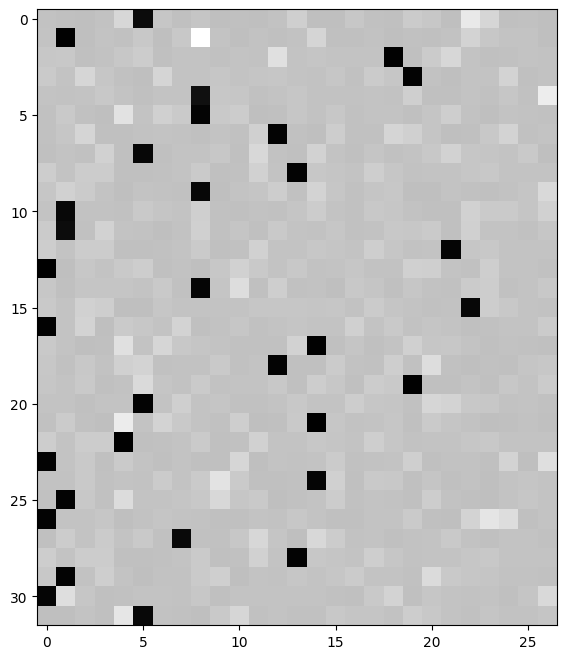

In [39]:
plt.figure(figsize=(8, 8))
plt.imshow(dlogits.detach(), cmap="gray")